In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb


In [2]:
df = pd.read_csv('data/train.csv')
df = df.drop(columns='id')
df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [3]:
X = df.drop(labels='Premium Amount', axis=1)
Y = np.log1p(df['Premium Amount'])

# nothing model
model = LinearRegression(fit_intercept=False)
res = cross_validate(estimator=model, X=np.ones((len(df), 1)), y=Y, scoring='neg_root_mean_squared_error')
res['test_score'].mean()

-1.0958205916002481

In [10]:
# LR model (fill na is 0)
model = LinearRegression()
res = cross_validate(estimator=model, X=X.select_dtypes('number').fillna(0), y=Y, scoring='neg_root_mean_squared_error')
res['test_score'].mean()

-1.0921773364721272

In [40]:
# XGB
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    n_jobs=-1,
    random_state=42
)

res = cross_validate(estimator=xgb_model, X=X.select_dtypes('number'), y=Y, scoring='neg_root_mean_squared_error', return_estimator=True)
res['test_score'].mean()

-1.057669310736665

In [4]:
# Hist gb
hist_X = X.copy()
hist_X['Policy Year'] = pd.to_datetime(hist_X['Policy Start Date']).dt.year
hist_X = hist_X.drop('Policy Start Date', axis=1)
categorical_indices = [hist_X.columns.get_loc(col) for col in hist_X.select_dtypes(include=['object']).columns]

hist_model = HistGradientBoostingRegressor(max_iter=100, categorical_features=categorical_indices)
res = cross_validate(estimator=hist_model, X=hist_X, y=Y, scoring='neg_root_mean_squared_error')
res['test_score'].mean()

-1.0458708588353491

In [4]:
# quick pipeline and submission
def extract_policy_year(df):
    df = df.copy()
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date']).dt.year
    return df

def modify_numerical(df):
    df = df.copy()
    df = df.drop(columns=['Age'])
    df['Number of Dependents'] = df['Number of Dependents'].isna().astype(int)
    df['Vehicle Age'] = df['Vehicle Age'].isna().astype(int)
    df['Insurance Duration'] = df['Insurance Duration'].isna().astype(int)
    return df

def modify_categorical(df):
    df = df.copy()
    df = df.drop(columns=['Gender', 'Education Level', 'Location', 'Policy Type', \
                          'Smoking Status', 'Exercise Frequency', 'Property Type'])
    df['Marital Status'] = df['Marital Status'].isna().astype(int)
    df['Occupation'] = df['Occupation'].isna().astype(int)
    df['Customer Feedback'] = df['Customer Feedback'].isna().astype(int)
    return df

def combine(df):
    df = extract_policy_year(df)
    df = modify_numerical(df)
    df = modify_categorical(df)
    return df


class HistGBWithDynamicCats(BaseEstimator, RegressorMixin):
    def __init__(self, **params):
        self.params = params
        self.model = HistGradientBoostingRegressor(**params)
    
    def fit(self, X, y):
        # Infer categorical indices dynamically after transformation
        self.categorical_indices_ = [
            X.columns.get_loc(col) for col in X.select_dtypes(include=['object']).columns
        ]
        # Pass these indices to the model
        self.model.set_params(categorical_features=self.categorical_indices_)
        return self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)

pipeline = Pipeline([
    ('transform', FunctionTransformer(combine)),
    ('model', HistGBWithDynamicCats(max_iter=100))
    ])

In [32]:
res = cross_validate(estimator=pipeline, X=X, y=Y, scoring='neg_root_mean_squared_error')
res['test_score'].mean()

-1.0455433895652209

In [12]:
test_df = pd.read_csv('data/test.csv')
pipeline.fit(X, Y)
results = pipeline.predict(test_df)

In [19]:
transformed_results = np.expm1(results)
submission = pd.DataFrame({'Premium Amount': transformed_results}, index=test_df['id'])
submission.to_csv('./submission.csv', index=True)

In [67]:
# Test separate
X_filtered = combine(X)
X_filtered.head()

# XGB
xgb_model = xgb.XGBRegressor(
    n_estimators=1,
    learning_rate=1,
    max_depth=5,
    n_jobs=-1,
    random_state=42
)

X_filtered = X_filtered[['Annual Income', 'Health Score', 'Previous Claims', 'Credit Score',
       'Customer Feedback']]

res = cross_validate(estimator=xgb_model, X=X_filtered, y=Y, scoring='neg_root_mean_squared_error', return_estimator=True)
res['test_score'].mean()

-1.053932479861269

In [50]:
for i in range(5):
    features = res['estimator'][i].feature_importances_
    cols = X_filtered.loc[:,features > 0].columns
    print(features)

[0.1748324  0.12608553 0.17413922 0.26199746 0.26294535]
[0.25286067 0.08248939 0.18362077 0.3145646  0.16646458]
[0.1956817  0.09942912 0.18763836 0.26354927 0.25370148]
[0.18681802 0.08703575 0.21213093 0.25489435 0.25912097]
[0.13425995 0.10556234 0.26514706 0.249469   0.24556158]


In [64]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

decision = DecisionTreeRegressor(max_depth=5)
res = cross_validate(estimator=decision, X=X_filtered, y=Y, scoring='neg_root_mean_squared_error', return_estimator=True)
res['test_score'].mean()

-1.0537625561500117

[Text(0.5, 0.9166666666666666, 'Annual Income <= 46402.0\nsquared_error = 1.201\nsamples = 1200000\nvalue = 6.594'),
 Text(0.25, 0.75, 'Credit Score <= 430.5\nsquared_error = 0.992\nsamples = 897699\nvalue = 6.68'),
 Text(0.375, 0.8333333333333333, 'True  '),
 Text(0.125, 0.5833333333333334, 'Annual Income <= 5100.5\nsquared_error = 0.818\nsamples = 78895\nvalue = 6.815'),
 Text(0.0625, 0.4166666666666667, 'Health Score <= 48.737\nsquared_error = 0.959\nsamples = 26069\nvalue = 6.678'),
 Text(0.03125, 0.25, 'Annual Income <= 1145.5\nsquared_error = 0.97\nsamples = 24648\nvalue = 6.669'),
 Text(0.015625, 0.08333333333333333, 'squared_error = 0.952\nsamples = 5486\nvalue = 6.622'),
 Text(0.046875, 0.08333333333333333, 'squared_error = 0.975\nsamples = 19162\nvalue = 6.683'),
 Text(0.09375, 0.25, 'Annual Income <= 592.5\nsquared_error = 0.743\nsamples = 1421\nvalue = 6.83'),
 Text(0.078125, 0.08333333333333333, 'squared_error = 1.418\nsamples = 85\nvalue = 6.48'),
 Text(0.109375, 0.083333

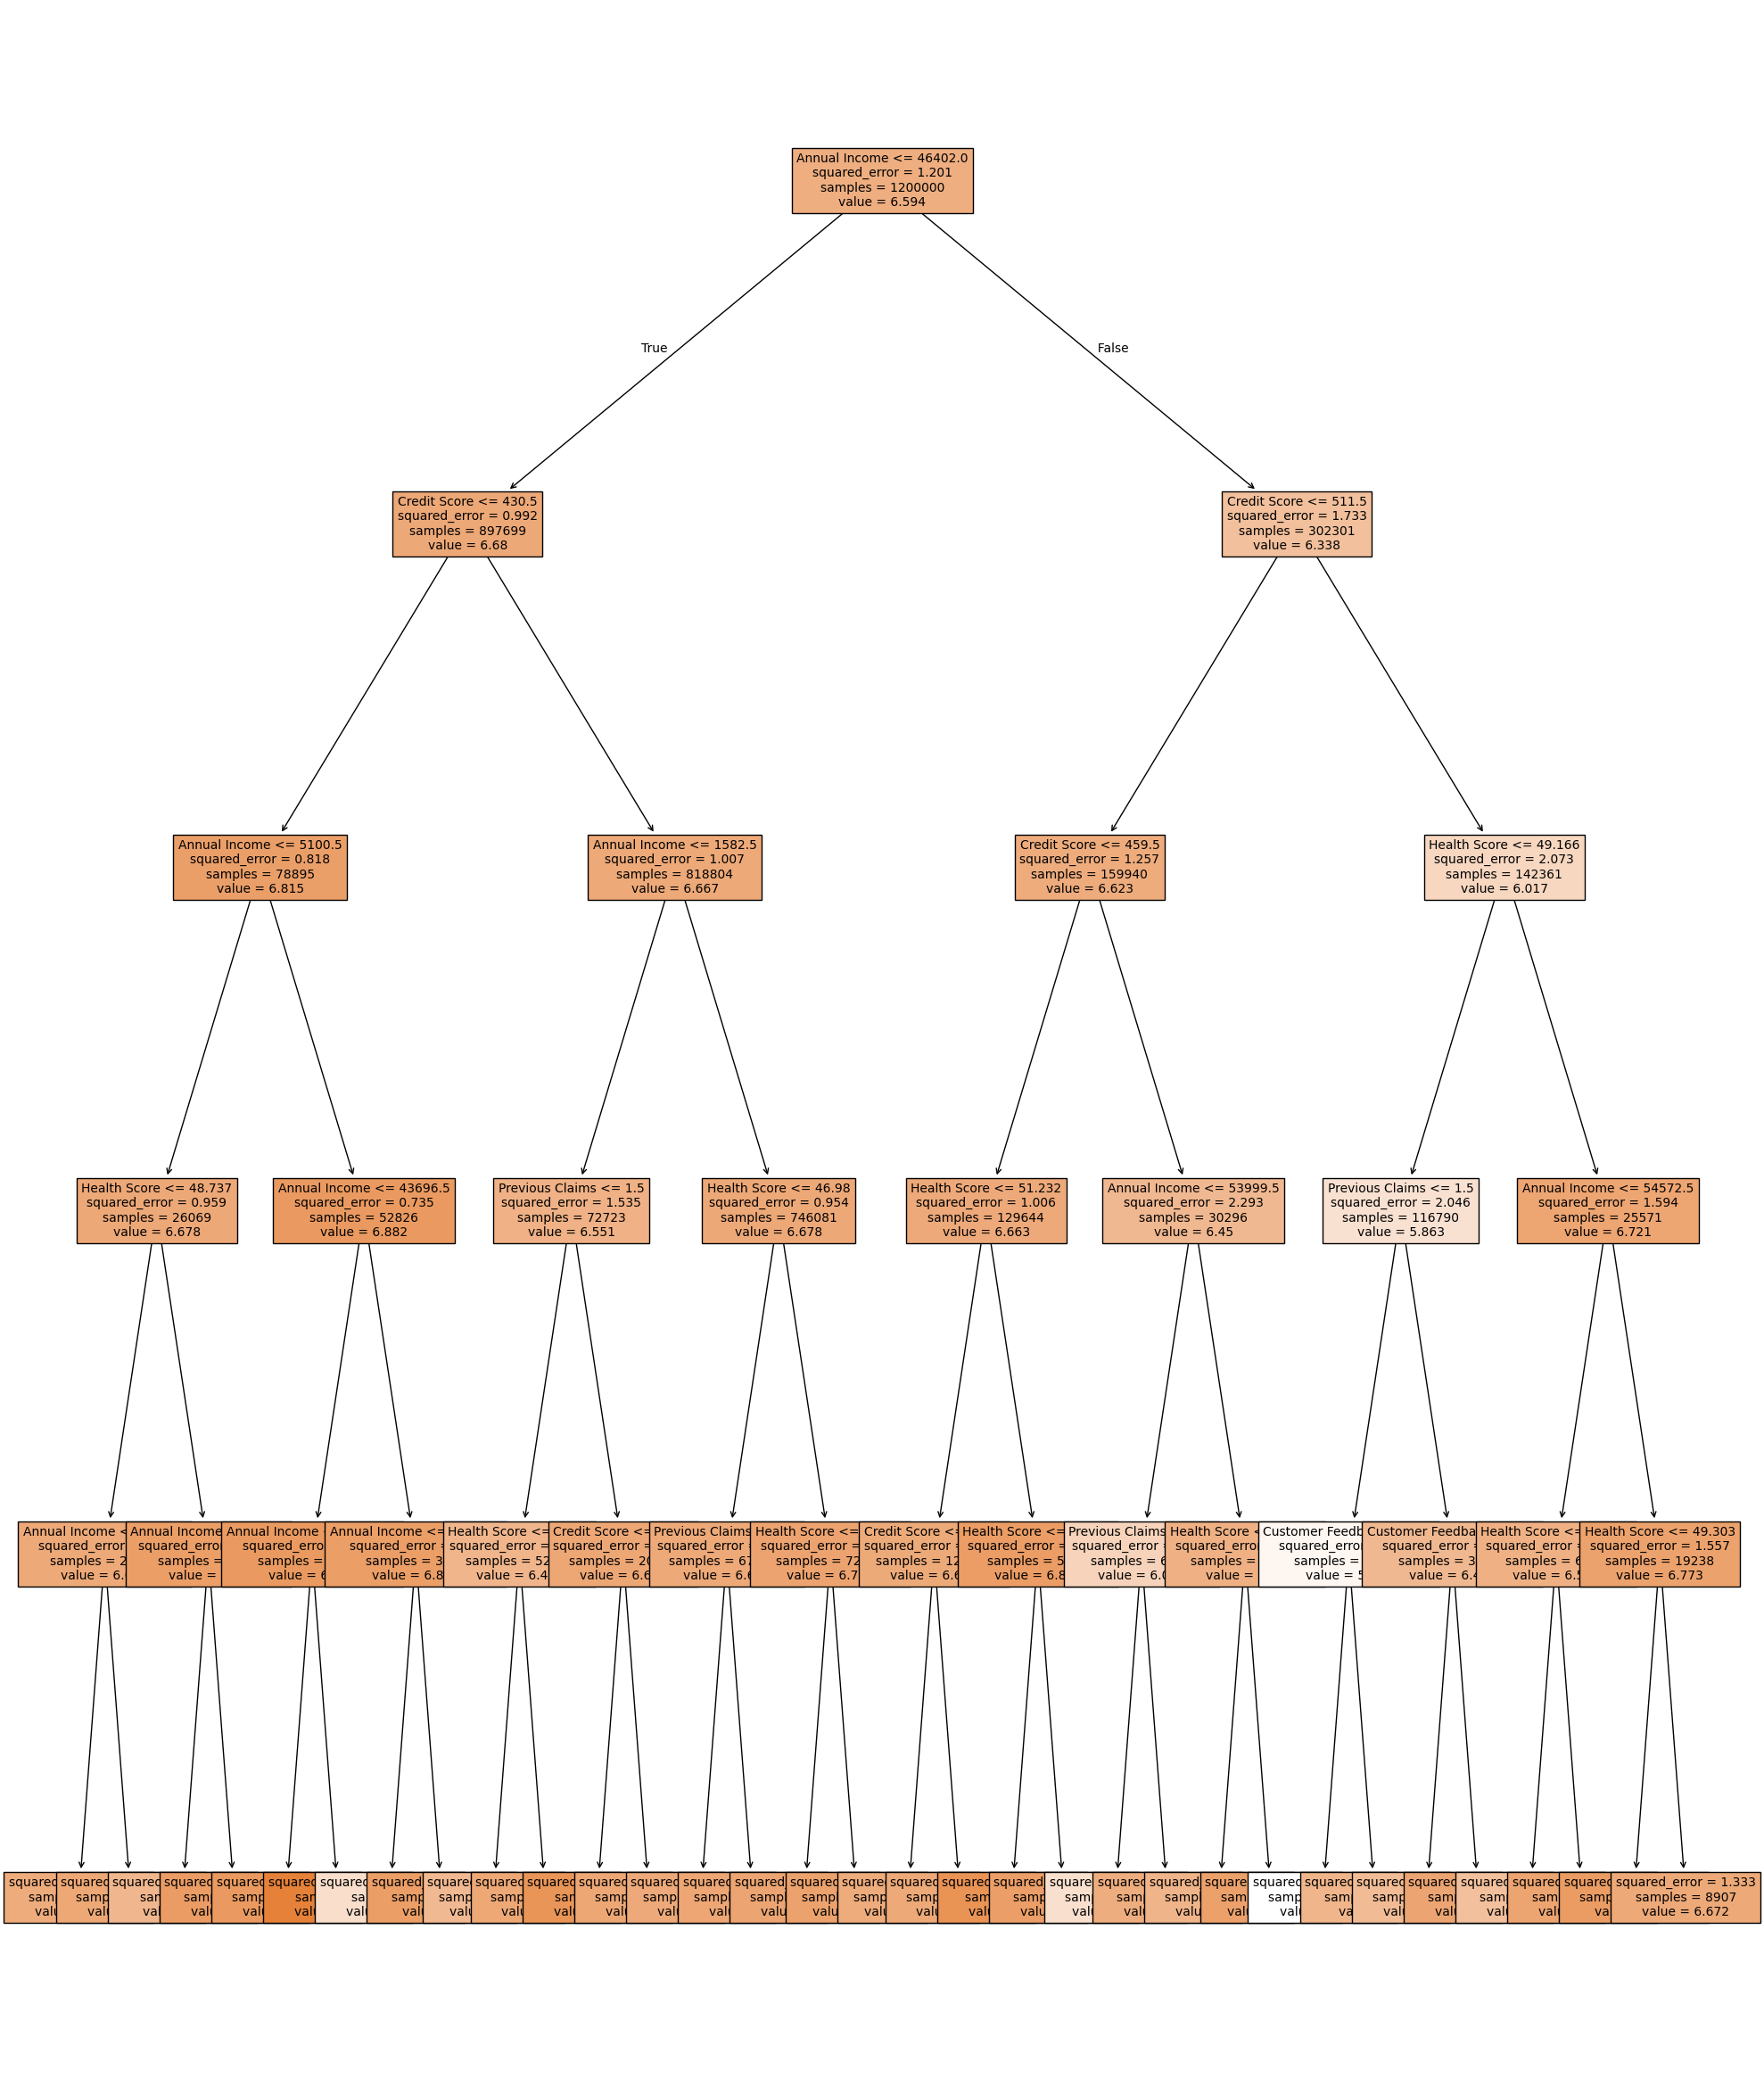

In [65]:
overall = decision.fit(X_filtered, Y)

plt.figure(figsize=(24, 30))
plot_tree(overall, feature_names=X_filtered.columns, filled=True, fontsize=10)

In [66]:
X_filtered

,Annual Income,Health Score,Previous Claims,Credit Score,Customer Feedback
0,10049.0,22.598761,2.0,372.0,0
1,31678.0,15.569731,1.0,694.0,0
2,25602.0,47.177549,1.0,NaN,0
3,141855.0,10.938144,1.0,367.0,0
4,39651.0,20.376094,0.0,598.0,0
...,...,...,...,...,...
1199995,27316.0,13.772907,NaN,372.0,0
1199996,35786.0,11.483482,NaN,597.0,0
1199997,51884.0,14.724469,0.0,NaN,0
1199998,NaN,18.547381,1.0,407.0,0
